In [1]:
!pip install pybbn


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.dag import Edge,EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
pd.options.display.max_columns=50

In [3]:
df=pd.read_csv('weatherAUS.csv',encoding='utf-8')


In [4]:
df=df[pd.isnull(df['RainTomorrow'])==False]


In [5]:
df=df.fillna(df.mean())


C:\Users\admin\AppData\Local\Temp\ipykernel_1296\2390430405.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df=df.fillna(df.mean())


In [6]:
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')


In [7]:
print(df)

              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW 

In [8]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob

In [9]:
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

In [10]:
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

In [11]:
join_tree = InferenceController.apply(bbn)


In [12]:
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}



In [13]:
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}


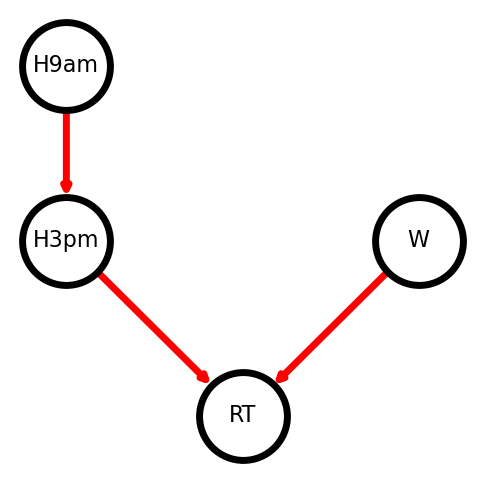

In [14]:
n, d = bbn.to_nx_graph()

fig, ax = plt.subplots(figsize=(6, 6))

nx.draw(n, pos=pos, with_labels=True, labels=d, ax=ax, **options)

ax.margins(0.10)
plt.axis("off")
plt.show()